In [2]:
%%capture
!pip install torchmetrics

In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

from torchmetrics import F1Score

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

from tqdm.notebook import tqdm

nltk.download('punkt_tab')

import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Дополнительное задание 3 - 5 баллов

В этом задании вам предстоит обучить две модели для предсказания рейтинга отзывов об отелях.

# 1. Загрузите датасет отзывов - [Trip Advisor Hotel Reviews](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews)

In [5]:
df = pd.read_csv(f"/content/tripadvisor_hotel_reviews.csv")
print(df.shape)
df.head()

(20491, 2)


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [6]:
df['Rating'].value_counts()

,count
Rating,
5,9054
4,6039
3,2184
2,1793
1,1421


# 2.Подготовьте данные к обучению - **1 балл**
    - Разделите датасет на обучающую, валидационную и тестовую выборки со стратификацией в пропорции 60/20/20.
    - Создайте `Dataset` и `DataLoader` для обучающей, валидационной и тестовой выборок. Выберите оптимальный, на ваш взгляд, `batch_size`.

In [7]:
class TextDataWrapper(Dataset):
    def __init__(self, reviews, ratings, tokenizer, max_length=128):
        self.reviews = reviews
        self.ratings = ratings
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        rating = self.ratings[idx]

        encoded = self.tokenizer.encode_plus(
            review,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt',
            return_attention_mask=True
        )

        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'labels': torch.tensor(rating - 1, dtype=torch.long)
        }

In [8]:
X = df['Review'].values
y = df['Rating'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = TextDataWrapper(X_train, y_train, tokenizer)
val_dataset = TextDataWrapper(X_val, y_val, tokenizer)
test_dataset = TextDataWrapper(X_test, y_test, tokenizer)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# 3.Реализуйте и обучите сверточную сеть (сеть с использованием слоев Conv1d) для решения задачи - **1 балл**

In [9]:
class ConvTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, out_channel, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)

    def forward(self, x):
        output = self.embedding(x)
        output = output.permute(0, 2, 1) # bs, emb_dim, len
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        return output

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, f1, epochs):
  list_train_epoch_loss, list_train_epoch_f1 = [], []
  list_val_epoch_loss, list_val_epoch_f1 = [], []

  for epoch in range(1,epochs+1):
      print(f"Train epoch {epoch}/{epochs}")
      model.train()
      temp_loss, temp_metrics = [], []

      for batch in train_loader:
          optimizer.zero_grad()
          data = batch['input_ids']
          target = batch['labels']
          output = model(data)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()

          temp_loss.append(loss.float().item())
          temp_metrics.append(f1(output.argmax(1), target).item())

      epoch_loss = np.array(temp_loss).mean()
      list_train_epoch_loss.append(epoch_loss)
      epoch_f1 = np.array(temp_metrics).mean()
      list_train_epoch_f1.append(epoch_f1)
      print(f'Loss train: {epoch_loss}, f1 score train: {epoch_f1}')

      # Валидация
      model.eval()
      with torch.no_grad():
        temp_loss, temp_metrics = [], []

        for batch in val_loader:
            data = batch['input_ids']
            target = batch['labels']
            output = model(data)
            loss = criterion(output, target)

            temp_loss.append(loss.float().item())
            temp_metrics.append(f1(output.argmax(1), target).item())

        epoch_loss = np.array(temp_loss).mean()
        list_val_epoch_loss.append(epoch_loss)
        epoch_f1 = np.array(temp_metrics).mean()
        list_val_epoch_f1.append(epoch_f1)
        print(f'Loss val: {epoch_loss}, f1 score val: {epoch_f1}')

  return   list_train_epoch_loss, list_train_epoch_f1, list_val_epoch_loss, list_val_epoch_f1

In [14]:
epochs = 10

model = ConvTextClassifier(vocab_size=tokenizer.vocab_size, embedding_dim=128, out_channel=256, num_classes=5)
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

f1 = F1Score(task="multiclass", num_classes=5, average='macro')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

cnn_res = train_model(model, train_loader, val_loader, criterion, optimizer, f1, epochs)

ConvTextClassifier(
  (embedding): Embedding(30522, 128)
  (conv): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=256, out_features=5, bias=True)
)
Parameters: 4006661
Train epoch 1/10
Loss train: 1.3026009551635602, f1 score train: 0.1891460835138654
Loss val: 1.223457607118095, f1 score val: 0.21351350967477006
Train epoch 2/10
Loss train: 1.1195172235006239, f1 score train: 0.2934671823571368
Loss val: 1.1085150805915274, f1 score val: 0.29533541289771476
Train epoch 3/10
Loss train: 0.9948017109458039, f1 score train: 0.40924083556889035
Loss val: 1.031035472997805, f1 score val: 0.3728804451299877
Train epoch 4/10
Loss train: 0.8989087966157169, f1 score train: 0.4870908497310266
Loss val: 0.9926695454411391, f1 score val: 0.387883755855444
Train epoch 5/10
Loss train: 0.8222558563075415, f1 score train: 0.5549562934513499
Loss val: 0.947417171117736, f1 score val: 0.4119372753835306
Train epoch 6/10
Loss train: 0.7572542665935145, 

# 4.Реализуйте и обучите рекуррентную сеть (сеть с использованием LSTM-слоя) для решения задачи - **1 балл**

In [11]:
class LSTMTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.linear(output[:, -1, :])
        return output

In [12]:
epochs = 10

model = LSTMTextClassifier(vocab_size=tokenizer.vocab_size, embedding_dim=128, hidden_size=256, num_classes=5)
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

f1 = F1Score(task="multiclass", num_classes=5, average='macro')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

lstm_res = train_model(model, train_loader, val_loader, criterion, optimizer, f1, epochs)

LSTMTextClassifier(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=5, bias=True)
)
Parameters: 4303365
Train epoch 1/10
Loss train: 1.3606744467485241, f1 score train: 0.14845030691656397
Loss val: 1.3505548721406517, f1 score val: 0.14649201869601156
Train epoch 2/10
Loss train: 1.3511306789590092, f1 score train: 0.14949845216668597
Loss val: 1.3516874127271699, f1 score val: 0.161218078270918
Train epoch 3/10
Loss train: 1.3462033303772531, f1 score train: 0.15875629546211623
Loss val: 1.3460797205203916, f1 score val: 0.16122052446007729
Train epoch 4/10
Loss train: 1.3267038263198807, f1 score train: 0.17565059445616676
Loss val: 1.342131984815365, f1 score val: 0.17520717816745363
Train epoch 5/10
Loss train: 1.3012549880074291, f1 score train: 0.2132402730583236
Loss val: 1.304109177356813, f1 score val: 0.20145010250370676
Train epoch 6/10
Loss train: 1.2489084434218523, f1 score train: 0.24077302

# 5.Сравните между собой метрики и динамику обучения обеих моделей - **1 балл**

**Общее**

Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - **1 балл**

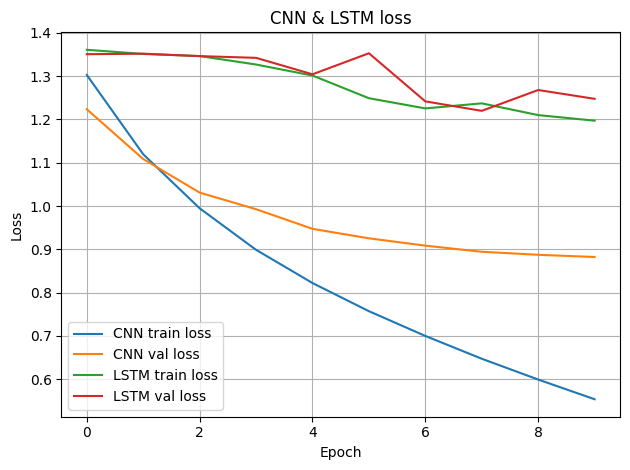

In [26]:
plt.plot(cnn_res[0], label='CNN train loss')
plt.plot(cnn_res[2], label='CNN val loss')
plt.plot(lstm_res[0], label='LSTM train loss')
plt.plot(lstm_res[2], label='LSTM val loss')
plt.title('CNN & LSTM loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.legend()
plt.tight_layout()
plt.show()

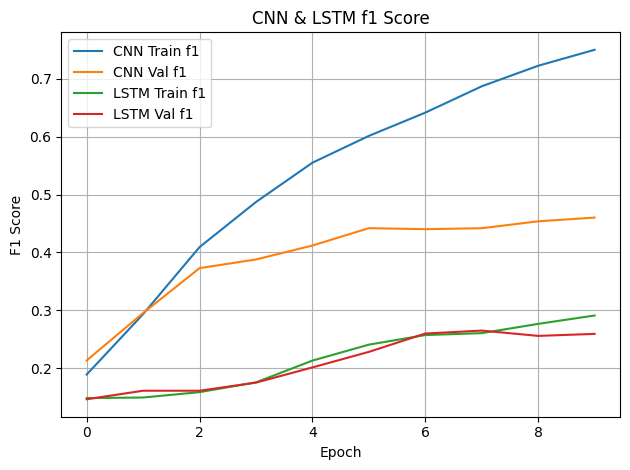

In [27]:
plt.plot(cnn_res[1], label='CNN Train f1')
plt.plot(cnn_res[3], label='CNN Val f1')
plt.plot(lstm_res[1], label='LSTM Train f1')
plt.plot(lstm_res[3], label='LSTM Val f1')
plt.title('CNN & LSTM f1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)

plt.legend()
plt.tight_layout()
plt.show()

Вывод:

**CNN**:

Видим что модель довольно быстро начинает переобучаться => можно поробовать, например:
1. лучше подбирать гиперпараметры
2. использовать более сложную архитектуру модели (напр. использовать больше слоёв)
3. использовать больше данных для обучения

**LSTM**:

LSTM модели требудется намного больше эпох для обучения чем для CNN, в данном случае также видим что 10 эпох недостаточно. Также видим что loss стабильно снижается, а f1 растёт, что хорошо